### Data Science 100 - Final Project

An investigation of the popularity of certain play-times using data from a MineCraft server. 

By Group #4: Chloe Glesby, Ryann Wilson, Victoria Levner

#### Introduction:
MineCraft, published by Mojang Studios is an online video game where users can place ‘blocks’ to create and build different structures. The game has a multiplayer aspect where users can interact and collaborate. The Pacific Laboratory for Artificial Intelligence (PLAI), founded by Professor Frank Wood created a MineCraft server to conduct research and data analysis about this video game and its users. Once players log onto this specific server, all kinds of data is being collected. Some examples of this data include the kind of player they are, the time of day they log on and off, and what things they say while playing. This information can be useful for the PLAI team as it can showcase patterns to help formulate models for prediction purposes. These predictions can be used in many aspects of video game research including what the most popular times will be and how many people the server needs to accommodate - which is the goal of this data analysis. 

Using the PLAI team’s Minecraft data, an analysis will be conducted in order to answer:
- How does the popularity of playing the game differ throughout the day?

Popularity is determined by:
  - The number of players on the game
  - The number of minutes played per session


To begin the data anlysis, some Python packages must first be imported into the notebook:

In [1]:
import numpy as np
import pandas as pd
import altair as alt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from IPython.display import display, Markdown

# Simplify working with large datasets in Altair
alt.data_transformers.enable('vegafusion')

# Output dataframes instead of arrays
set_config(transform_output="pandas")

Next, the data was loaded as a simple data frame using the 'pandas' package 

In [2]:
sessions_data = pd.read_csv(
    'https://drive.google.com/uc?id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB'
) # the file path for the dataframe in brackets
sessions_data.head(10)

,hashedEmail,start_time,end_time,original_start_time,original_end_time
0,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431...,30/06/2024 18:12,30/06/2024 18:24,1.719770e+12,1.719770e+12
1,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f5...,17/06/2024 23:33,17/06/2024 23:46,1.718670e+12,1.718670e+12
2,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3...,25/07/2024 17:34,25/07/2024 17:57,1.721930e+12,1.721930e+12
3,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431...,25/07/2024 03:22,25/07/2024 03:58,1.721880e+12,1.721880e+12
4,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f5...,25/05/2024 16:01,25/05/2024 16:12,1.716650e+12,1.716650e+12
5,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431...,23/06/2024 15:08,23/06/2024 17:10,1.719160e+12,1.719160e+12
6,fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33...,15/04/2024 07:12,15/04/2024 07:21,1.713170e+12,1.713170e+12
7,ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b1...,21/09/2024 02:13,21/09/2024 02:30,1.726880e+12,1.726890e+12
8,96e190b0bf3923cd8d349eee467c09d1130af143335779...,21/06/2024 02:31,21/06/2024 02:49,1.718940e+12,1.718940e+12
9,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f5...,16/05/2024 05:13,16/05/2024 05:52,1.715840e+12,1.715840e+12


#### The Data 
The Sessions dataframe has 1535 observations and 5 variables which provide information about the time frames that players of the PLAICraft server logged on and off. 

https://drive.google.com/file/d/14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB/edit

- The column `hashedEmail` describes individual player email's in an encoded fashion, using a string of numbers and letters. The observations in this column are not useful in this data analysis, as the identify of the players is not important to the type of predictive questions in this analysis.  
- The columns `start_time` and `end_time` provide the exact time and date that players logged on and off the server in day-month-year-time format. This makes the data untidy though, as there are multiple variables within a cell. 
- The columns `original_start_time` and `original_end_time` are information about the log-on and off times in Unix time format. This column is not useful for this data analysis as it is in a time format that is difficult to manipulate and interpret.

Using the `count` - a simple numbered list of players, and the`start_time` and `end_time` columns, some prelminary data wrangling and filtering will be conducted to better visulize any patterns in the Sessions data set.






The start and end time format is easier to use than Unix time, but it will be more efficient to organize it into a format that Python recognizes and classifies as tidy:

In [3]:
#to convert the time into 'datetime' format and split each variable into a separate column

sessions_data['start_time'] = pd.to_datetime(sessions_data['start_time'],format='%d/%m/%Y %H:%M')
sessions_data['end_time'] = pd.to_datetime(sessions_data['end_time'],format='%d/%m/%Y %H:%M')
sessions_data["start_hour"] = sessions_data["start_time"].dt.hour
sessions_data["start_month"] = sessions_data["start_time"].dt.month
sessions_data["start_year"] = sessions_data["start_time"].dt.year 

# drop unnecessary columns 
sessions_data = sessions_data.drop(columns = ['hashedEmail','original_start_time','original_end_time'])

# tell python to show the new data set 
sessions_data

,start_time,end_time,start_hour,start_month,start_year
0,2024-06-30 18:12:00,2024-06-30 18:24:00,18,6,2024
1,2024-06-17 23:33:00,2024-06-17 23:46:00,23,6,2024
2,2024-07-25 17:34:00,2024-07-25 17:57:00,17,7,2024
3,2024-07-25 03:22:00,2024-07-25 03:58:00,3,7,2024
4,2024-05-25 16:01:00,2024-05-25 16:12:00,16,5,2024
...,...,...,...,...,...
1530,2024-05-10 23:01:00,2024-05-10 23:07:00,23,5,2024
1531,2024-07-01 04:08:00,2024-07-01 04:19:00,4,7,2024
1532,2024-07-28 15:36:00,2024-07-28 15:57:00,15,7,2024
1533,2024-07-25 06:15:00,2024-07-25 06:22:00,6,7,2024


Next, we created a column in the dataframe that calculates the total minutes played in each playing session. This will help us in determining how long playing sessions are during different time slots in the day.

In [4]:
sessions_data['time_played_mins'] = ((sessions_data['start_time'].dt.hour * 60 + sessions_data['start_time'].dt.minute) -
(sessions_data['end_time'].dt.hour * 60 + sessions_data['end_time'].dt.minute)).abs()
sessions_data.head(10)

,start_time,end_time,start_hour,start_month,start_year,time_played_mins
0,2024-06-30 18:12:00,2024-06-30 18:24:00,18,6,2024,12.0
1,2024-06-17 23:33:00,2024-06-17 23:46:00,23,6,2024,13.0
2,2024-07-25 17:34:00,2024-07-25 17:57:00,17,7,2024,23.0
3,2024-07-25 03:22:00,2024-07-25 03:58:00,3,7,2024,36.0
4,2024-05-25 16:01:00,2024-05-25 16:12:00,16,5,2024,11.0
5,2024-06-23 15:08:00,2024-06-23 17:10:00,15,6,2024,122.0
6,2024-04-15 07:12:00,2024-04-15 07:21:00,7,4,2024,9.0
7,2024-09-21 02:13:00,2024-09-21 02:30:00,2,9,2024,17.0
8,2024-06-21 02:31:00,2024-06-21 02:49:00,2,6,2024,18.0
9,2024-05-16 05:13:00,2024-05-16 05:52:00,5,5,2024,39.0


In [5]:
# Drop NA
sessions_data2 = sessions_data.dropna()
sessions_data2.head()

,start_time,end_time,start_hour,start_month,start_year,time_played_mins
0,2024-06-30 18:12:00,2024-06-30 18:24:00,18,6,2024,12.0
1,2024-06-17 23:33:00,2024-06-17 23:46:00,23,6,2024,13.0
2,2024-07-25 17:34:00,2024-07-25 17:57:00,17,7,2024,23.0
3,2024-07-25 03:22:00,2024-07-25 03:58:00,3,7,2024,36.0
4,2024-05-25 16:01:00,2024-05-25 16:12:00,16,5,2024,11.0


To complete our wrangling, we created another dataframe with the start hours and the total count of playing sessions that began in that hour. From this dataframe, will be able to easily visualize the distribution of playing hours, as well as easily perform our data analysis later.

In [6]:
start_hour_count = sessions_data2["start_hour"].value_counts()
start_hour_data = pd.DataFrame(start_hour_count).reset_index()
start_hour_data

,start_hour,count
0,2,152
1,4,150
2,3,131
3,0,128
4,23,122
5,21,91
6,22,89
7,5,88
8,1,79
9,20,74


#### Visualizations

Below are vizualizations comparing the relationship between hour of the day and number of playing sessions (`Number of playing sessions vs hour of the day`) and the relationship between hour of the day minutes played per session (`Total minutes per playing session vs hour the day`). In these vizualizations, we can see some obvious clusters, so we know clustering is an effective method of anaylsis to use. In `Number of playing sessions vs hour of the day`, we can see a cluster early in the day with a high number of playing sessions, a cluster mid-day with a low number of playing sessions, and a cluster late in the day with a high number of playing session. In `Total minutes per playing session vs hour the day`, we can see a cluster early in the day with few total minutes, a cluster late in the day with few total minutes, and a cluster late in the day with high total minutes.

In [7]:
hours_scatter = alt.Chart(start_hour_data).mark_point().encode(
    x=alt.X('start_hour').title('Hour of the day'),
    y=alt.Y('count').title('Number of players'),
).properties(title='Number of playing sessions vs hour of the day')

display(hours_scatter)
display(Markdown("**Figure 1.0:** Exploratory visualization of number of players active throughout the day."))

alt.Chart(...)

**Figure 1.0:** Exploratory visualization of number of players active throughout the day.

In [8]:
minutes_played_scatter = alt.Chart(sessions_data).mark_point().encode(
    x=alt.X("start_hour").title("Hour of the day"),
    y=alt.Y("time_played_mins").title("Total minutes per playing session")
).properties(title="Total minutes per playing session vs hour of the day")
minutes_played_scatter

display(minutes_played_scatter)
display(Markdown("**Figure 1.1:** Exploratory visualization of playing time throughout the day."))

alt.Chart(...)

**Figure 1.1:** Exploratory visualization of playing time throughout the day.

#### Data Summary

For our two questions, we are most interested in the number of players who began their playing session each hour, as well as the relationship between the length in minutes of each playing session and the hour in which the sessions began. For our first question, we can see from our `start_hour_data` dataframe and `Number of playing sessions vs hour of the day` visualization that 2 AM, 4 AM, and 3 AM are the most popular times for players to begin playing and 10 AM, 1 PM, and 12 PM are the least popular times for players to begin playing. For our second question, we can most clearly see the relationship between the variables in our vizualization, `Total minutes per playing session vs hour the day`. The most common time for a playing session to be long (> 1000 minutes) is late in the day, at hours between 8 PM and 11 PM.

In [9]:
time_played_plot = alt.Chart(sessions_data2).mark_bar().encode(
    x=alt.X('time_played_mins').title('Time played (min)').bin(maxbins=20),
    y=alt.Y('count()').title('Number of players')
).properties(title='Distribution of player count based on time played')

display(time_played_plot)
display(Markdown("**Figure 1.2:** Exploratory visualization showing how long players typically play for."))

alt.Chart(...)

**Figure 1.2:** Exploratory visualization showing how long players typically play for.

In [10]:
hours_plot = alt.Chart(sessions_data2).mark_bar().encode(
    x=alt.X('start_hour').title('Hour of the day').bin(maxbins=20),
    y=alt.Y('count()').title('Number of players')
).properties(title='Distribution of player count throughout the day')
hours_plot

display(hours_plot)
display(Markdown("**Figure 1.3:** Exploratory visualization showing how many players are typically active throughout the day."))

alt.Chart(...)

**Figure 1.3:** Exploratory visualization showing how many players are typically active throughout the day.

#### Method of Analysis

Since we are interested in analyzing how popularity playing the game differs throughout the day, we will be using clustering as our method of analysis to help group similar behaviours within the data. Because of it's unsupervised nature, clustering offers us an easy way to handle data that isn't already categorized. That being said, we can identify time-based patterns based on player activity and distinguish which hours are most and least popular to play. We will use clustering to determine **(1)** groupings of hours based on the number of people playing and **(2)** groupings of hours based on the number of minutes played per session. We will also use visualizations to display clustered activity trends throughout the hours of the day. With these clusters, we can highlight key time periods such as "high-activity hours," "moderate-activity hours," and "low-activity hours," which could prove useful in any future game development. 

Starting with determining **(1)** the number of people playing throughout different hours of the day, we scaled the data to ensure all features are contributing equally and ensure model accuracy. We also set a range of clusters to choose from later and compute the within-cluster sum of squares for each k-value in the range.

In [11]:
# Scale the data
players_preprocessor = make_column_transformer(
    (StandardScaler(), ['start_hour', 'count']),
    remainder = 'drop',
    verbose_feature_names_out=False,
)

# Range of clusters to choose from
players_ks = range(1, 11)

# Commpute WSSD for each k-value
players_wssd = [
    make_pipeline(
        players_preprocessor,
        KMeans(n_clusters=k, random_state=1234) # Always set this seed to reproduce data
    ).fit(start_hour_data)[1].inertia_ # Fit the pipeline and compute its WSSD
    for k in players_ks
]

Next, we created an elbow map to easily choose the most applicable amount of clusters.

In [12]:
# Create a new data frame with cluster data
players_model_stats = pd.DataFrame({
    'k' : players_ks,
    'wssd' : players_wssd,
})

# Elbow plot
players_elbow_plot = alt.Chart(players_model_stats).mark_line(point=True).encode(
    x=alt.X('k').title('Number of Clusters'),
    y=alt.Y('wssd').title('Within-cluster Sum of Squares'),
).properties(title='Elbow Plot (players)')

# Display plot and figure title
display(players_elbow_plot)
display(Markdown("**Figure 2.1:** Total WSSD for K clusters ranging from 1 to 10."))

alt.Chart(...)

**Figure 2.1:** Total WSSD for K clusters ranging from 1 to 10.

This visualization shows that 3 is the most optimal amount of clusters. This is because it is the last number with a significant decrease in WSSD. If we were to pick a lower number of clusters, our results would be overgeneralized. If we were to pick a higher number of clusters, we would run into the risk of subdividing clusters. 

Lastly, we created a new visualization that is colored accordingly to the three clusters.

In [13]:
# Preform clustering with 3 clusters
players_cluster_k3 = KMeans(n_clusters=3, random_state=1234)

# Create new pipeline
players_pipe = make_pipeline(players_preprocessor, players_cluster_k3).fit(start_hour_data)

# Assign clusters
clustered_players = start_hour_data.assign(
    cluster=players_pipe[1].labels_
)

# Visualization
players_cluster_plot = alt.Chart(clustered_players).mark_circle().encode(
    x=alt.X('start_hour').title('Hour of the Day'),
    y=alt.Y('count').title('Number of Players'),
    color=alt.Color('cluster:N').title('Cluster'),
).properties(title='Number of Players vs Hour of the Day')

# Display plots and figure titles 
display(players_cluster_plot)
display(Markdown("**Figure 2.2:** Clustering of session start times based on number of players active."))

alt.Chart(...)

**Figure 2.2:** Clustering of session start times based on number of players active.

Here, we can see that we have clusters for hours (0-9), (10-17), and (8-23).

We completed the same process to **(2)** cluster hours based on the amount of minutes played per session. 

In [14]:
# Scale the data
minutes_preprocessor = make_column_transformer(
    (StandardScaler(), ["start_hour", "time_played_mins"]),
    remainder="drop",
    verbose_feature_names_out=False
)

# Range of clusters to choose from
minutes_ks = range(1, 11)

# Commpute WSSD for each k-value
minutes_wssds = [
    make_pipeline(
        minutes_preprocessor,
        KMeans(n_clusters=k, random_state=1234) # Always set this seed to reproduce data
    ).fit(sessions_data2)[1].inertia_ # Fit the pipeline and compute its WSSD
    for k in minutes_ks
]

# Create a new data frame
minutes_model_stats = pd.DataFrame({
    "k":minutes_ks,
    "wssd":minutes_wssds
})

# Elbow plot
minutes_elbow_plot = alt.Chart(minutes_model_stats).mark_line(point=True).encode(
    x=alt.X("k").title("Number of Clusters"),
    y=alt.Y("wssd").title("Total Within-cluster Sum of Squares")
).properties(title = 'Elbow Plot (minutes)')

# Preform clustering with 3 clusters
minutes_kmeans = KMeans(n_clusters=3, random_state=1234)

# Create a new pipeline and fit data
minutes_pipe = make_pipeline(minutes_preprocessor, minutes_kmeans)
minutes_pipe.fit(sessions_data2)

# Assign clusters
minutes_clustered = sessions_data2.assign(
    cluster = minutes_pipe[1].labels_
)

# Visualization
minutes_scatter_clustered = alt.Chart(minutes_clustered).mark_circle().encode(
    x=alt.X('start_hour').title('Hour of The Day'),
    y=alt.Y('time_played_mins').title('Total Playing Time per Session (minutes)'),
    color=alt.Color('cluster:N').title('Cluster'),
).properties(title='Playing Time vs. Hour of the Day')

# Display plots and figure titles
display(minutes_elbow_plot)
display(Markdown("**Figure 2.3:** Total WSSD for K clusters ranging from 1 to 10."))

display(minutes_scatter_clustered)
display(Markdown("**Figure 2.4:** Clustering of session start times based on time played."))

alt.Chart(...)

**Figure 2.3:** Total WSSD for K clusters ranging from 1 to 10.

alt.Chart(...)

**Figure 2.4:** Clustering of session start times based on time played.

With `Elbow Plot (minutes)` we can clearly see that 3 is the best choice for the number of clusters when grouping hours based on the playing time. In the `Playing Time vs. Hour of the Day` plot, we can see that there are clusters for the hours (0-10), (12-23), and (20-23).

#### Predictive Analysis (KNN Regression)

During the exploratory analysis, we performed clustering to understand the inherent patterns in the distribution of player activity throughout the day. By grouping sessions based on their start hour and the time played, we were able to observe trends in how players engage with the game at different times. This gives us insight on the behavior of players and can lead to speculation about why these patterns are occuring. With the clustering analysis offering a view of how sessions are distributed throughout the day, we now move on to predicting the number of players (or the total playing time) at different hours of the day using K-Nearest Neighbors (KNN) regression. While clustering helped us identify patterns, KNN regression allows us to build a predictive model that can estimate time played for any given hour of the day. This transition from clustering to regression is essential because, while clustering reveals groups or patterns, KNN regression provides a means to quantify these trends and make predictions for future instances which can be helpful to PLAICraft researchers. We will be using KNN in this case because the data is non-linear.

In [25]:
# Split the data into training and testing sets
sessions_train, sessions_test = train_test_split(
    sessions_data2, train_size=0.75, random_state=2000
)

# Identify feature data and target data in testing and training sets
X_train = sessions_train[['start_hour']] 
y_train = sessions_train['time_played_mins'] 

X_test = sessions_test[['start_hour']]
y_test = sessions_test['time_played_mins'] 

# Preprocess the data and make a pipeline
sessions_preprocessor = make_column_transformer((StandardScaler(), ['start_hour']))
sessions_pipe = make_pipeline(sessions_preprocessor,KNeighborsRegressor())

# Create 5-fold GridSearchCV object
param_grid = {
    "kneighborsregressor__n_neighbors": range(1, 201, 3),
}
sessions_gridsearch = GridSearchCV(
    estimator=sessions_pipe,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
)

# Dit the GridSearchCV object
sessions_gridsearch.fit(X_train,y_train)

# Find which parameter value results in the lowest RMSPE
# sessions_gridsearch.best_params_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['start_hour'])])),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             param_grid={'kneighborsregressor__n_neighbors': range(1, 201, 3)},
             scoring='neg_root_mean_squared_error')

From the `best_params` function of GridSearchCV, we can see that the most optimal value of `k` in the KNN Model is 31. GridSearchCV will automatically apply the best parameter when used for predictions.

In [16]:
# Evaluating on the test set
sessions_test["predicted"] = sessions_gridsearch.predict(sessions_test)
RMSPE = mean_squared_error(
    y_true=sessions_test["time_played_mins"],
    y_pred=sessions_test["predicted"]
)**(1/2)
RMSPE

np.float64(253.58081856324594)

In [17]:
# Assign predictions to data 
sessions_preds = sessions_train.assign(
    predictions= sessions_gridsearch.predict(sessions_train[['start_hour']])
)

# Plotting the data
base_plot = alt.Chart(sessions_preds).mark_circle(opacity=0.4).encode(
    x=alt.X('start_hour').title('Hour of the Day'),
    y=alt.Y('time_played_mins').title('Total Playing Time per Session (minutes)'),
)

# Plotting the predictions
pred_line = (
    alt.Chart(sessions_preds)
    .mark_line(color='black')
    .encode(
        x='start_hour',
        y='predictions'
    )
)

# Visualizing the data and predictions together
sessions_plot = alt.layer(base_plot, pred_line).properties(
    title='Total time played vs. Hour of the Day'
)
# Create a figure title and display the plot
display(sessions_plot)
display(Markdown("**Figure 5:** Predicted values of playing time (black line) for the KNN regression model."))

alt.LayerChart(...)

**Figure 5:** Predicted values of playing time (black line) for the KNN regression model.

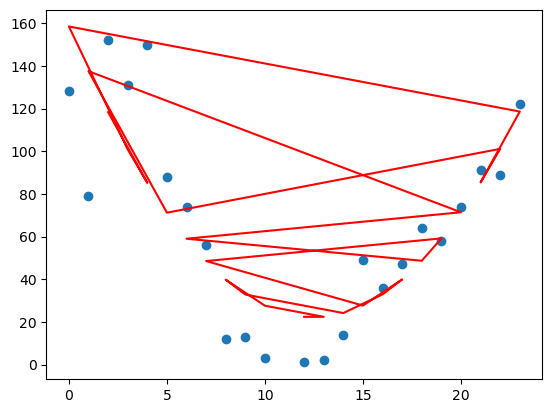

In [18]:
# start_hour_array = pd.DataFrame(start_hour_data).to_numpy()
# start_hour_count_array
x = start_hour_data[["start_hour"]]
y = start_hour_data[["count"]]
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(x.values.reshape(-1, 1))
lm = LinearRegression()
lm.fit(poly_features, y)
y_predicted = lm.predict(poly_features)
plt.scatter(x, y)
plt.plot(x, y_predicted, c="red")
plt.show()
# y_predicted

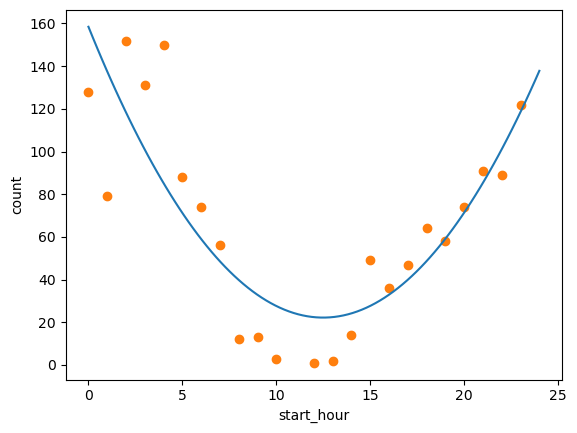

        2
0.8732 x - 21.82 x + 158.5
0.7029389733376261


In [19]:
# importing packages and modules 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import r2_score 
import scipy.stats as stats 
 
sns.scatterplot(data=start_hour_data, x='start_hour', 
				y='count') 

# plt.title('time vs height of the ball') 
# plt.xlabel('time') 
# plt.ylabel('height') 
# plt.show() 

# degree 2 polynomial fit or quadratic fit 
model = np.poly1d(np.polyfit(start_hour_data['start_hour'], 
							start_hour_data['count'], 2)) 

# polynomial line visualization 
polyline = np.linspace(0, 24, 100) 
plt.scatter(start_hour_data['start_hour'], start_hour_data['count']) 
plt.plot(polyline, model(polyline)) 
plt.show() 

print(model) 

# r square metric 
print(r2_score(start_hour_data['count'], 
			model(start_hour_data['start_hour']))) 


In [86]:
hour_train, hour_test = train_test_split(
    start_hour_data, test_size=0.3, random_state=2020
)
X_train2 = hour_train[['start_hour']] 
y_train2 = hour_train['count'] 

X_test2 = hour_test[['start_hour']]
y_test2 = hour_test['count']

# X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.33, random_state=42)

# Preprocess the data and make a pipeline
# hour_preprocessor = make_column_transformer((StandardScaler(), ['start_hour']))
scaler = StandardScaler()
X_train2_scaler = scaler.fit_transform(X_train2)
X_test2_scaler = scaler.transform(X_test2)

# hour_pipe = make_pipeline(hour_preprocessor,KNeighborsRegressor())
lin = LinearRegression()
hour_poly = PolynomialFeatures(degree=2)

X_train_poly = hour_poly.fit_transform(X_train2_scaler)
X_test_poly = hour_poly.transform(X_test2_scaler)

hour_poly.fit(X_train_poly, y_train2)
hour_fit = hour_lm.fit(X_train_poly, y_train2)

# y_pred = lin.predict(X_test_poly)

In [82]:
print(f"coefficients: {hour_fit.coef_.tolist()}")
print(f"intercept: {hour_fit.intercept_}")

coefficients: [0.0, -20.965400697234806, 43.69557533245209]
intercept: 18.12795407931261


In [83]:
hour_preds = hour_train.assign(
    predictions = hour_fit.predict(X_train_poly)
)
# hour_preds
scatterplot = alt.Chart(hour_preds).mark_circle().encode(
    x=alt.X("start_hour").title("Maximum distance ran per week"),
    y=alt.Y("count").title("Marathon time (hours)")
)
marathon_plot = scatterplot + alt.Chart(hour_preds).mark_line(color="black").encode(
    x="start_hour",
    y="predictions"
)
marathon_plot

alt.LayerChart(...)

In [84]:
test_preds = hour_test.assign(
    predictions = hour_fit.predict(X_test_poly)
)
hour_rmspe = mean_squared_error(
    y_true=y_test2,
    y_pred=test_preds["predictions"]
)**(1/2)
hour_rmspe

np.float64(32.765644991278656)

In [87]:
hour_plot = alt.Chart(hour_test).mark_circle().encode(
    x=alt.X("start_hour").title("Maximum distance ran per week"),
    y=alt.Y("count").title("Marathon time (hours)")
)
marathon_plot_test = marathon_plot + alt.Chart(test_preds).mark_line(color="black").encode(
    x="start_hour",
    y="predictions"
)
marathon_plot_test
# test_preds

alt.LayerChart(...)

In [ ]:
# hour_predictions = ames_testing.assign(
#     predictions = ames_fit.predict(X_test_ames)
# )
# ames_rmspe = mean_squared_error(
#     y_true = y_test_ames,
#     y_pred = ames_predictions[["predictions"]]
# )**(1/2)
# ames_rmspe

# hour_preds = hour_train.assign(
#     predictions = hour_fit.predict(hour_train[['start_hour_sq']])
# )
# # hour_preds
# scatterplot = alt.Chart(hour_preds).mark_point().encode(
#     x=alt.X("start_hour_sq").title("Maximum distance ran per week"),
#     y=alt.Y("count").title("Marathon time (hours)")
# )
# marathon_plot = scatterplot + alt.Chart(hour_preds).mark_line(color="black").encode(
#     x="start_hour_sq",
#     y="predictions"
# )
# marathon_plot